In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)

import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from pref_viewing.utils import plot_imgs
from dim_redu_anns.utils import get_relevant_output_layers
from sklearn.cluster import KMeans
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
import math


In [2]:
transform = transforms.Compose(
    [      
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
) #       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet", transform=transform)

In [11]:

def get_k_imgs(dim_rid1, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    
    topk_indices = sorted_indices[-k:][::-1]  # descending: highest values
    bottomk_indices = sorted_indices[:k] 
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

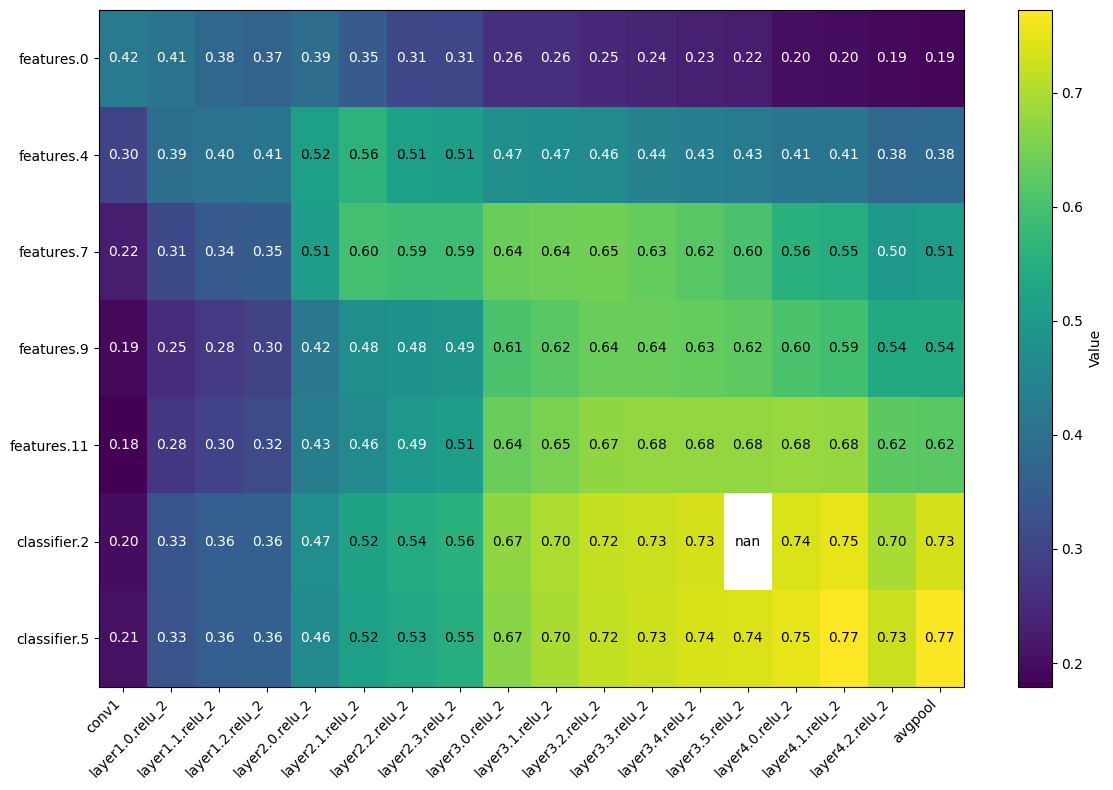

In [3]:
y_mod = "resnet50"
x_mod = "alexnet"
x_labels = get_relevant_output_layers(y_mod)
y_labels = get_relevant_output_layers(x_mod)
path2figs = "/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs"
pooling = "maxpool"
if y_mod == "vit_b_16":
    x_labels = ["conv_proj", "block_0", "block_2", "block_4", "block_6", "block_8", "block_10",  "block_11", "encoder", "heads"] #get_relevant_output_layers("vit_b_16")
plt.figure(figsize=(12, 8)) 
p = f"{paths["results_path"]}/cca_{x_mod}_vs_{y_mod}_{pooling}/{x_mod}_vs_{y_mod}_similarity_layers_pca.csv"
#p = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/cca_resnet50_vs_vit_b_16_maxpool/resnet50_vs_vit_b_16_similarity_layers_pca.csv"
df = np.loadtxt(p, delimiter=",")
plt.imshow(df, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        value = df[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='white' if value < 0.5 else 'black')
#y_labels = get_relevant_output_layers("alexnet")

plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.tight_layout()
#plt.savefig(f"{path2figs}/rsa_between_layers_pca_{y_mod}_vs_{x_mod}_{pooling}.png", dpi=300, bbox_inches='tight')
#print(f"{path2figs}/rsa_between_layers_pca_{y_mod}_vs_{x_mod}_{pooling}.png")

In [4]:
model_name1 = "alexnet"
model_name2 = "resnet50"
mod1_layers = get_relevant_output_layers(model_name1)
mod2_layers = get_relevant_output_layers(model_name2)

In [5]:
print(mod1_layers[1])
print(mod2_layers[5])

features.4
layer2.1.relu_2


In [6]:

target_layer1 = mod1_layers[1]
target_layer2 = mod2_layers[5]

pooling = "maxpool"
n_components_cca = 50
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
PCs2_path = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_pca_model_1000_PCs.pkl"
PCs2 = joblib.load(PCs2_path)
if (feats1.shape[1]>1000) or (feats2.shape[1]>1000):
    cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_pca_{target_layer1}_vs_{target_layer2}.pkl"
else:
    cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_{target_layer1}_vs_{target_layer2}.pkl"
weights_dict = joblib.load(cca_path)

In [7]:

dim_rid1 = feats1@PCs1.components_.T
if feats1.shape[1]>1000:
    d1 = dim_rid1 @ weights_dict["W1"]
else:
    d1 = feats1 @ weights_dict["W1"]

In [8]:
dim_rid2 = feats2@PCs2.components_.T
if feats2.shape[1]>1000:
    d2 = dim_rid2 @ weights_dict["W2"]
else:
    d2 = feats2 @ weights_dict["W2"]

In [23]:
k = 64
dim = 0
mod1_topk_imgs, mod1_bottomk_imgs = get_k_imgs(dim_rid1, dataset, k, dim)
mod2_topk_imgs, mod2_bottomk_imgs = get_k_imgs(dim_rid2, dataset, k, dim)
mod1_topk_imgs_cca, mod1_bottomk_imgs_cca = get_k_imgs(d1, dataset, k, dim)
mod2_topk_imgs_cca, mod2_bottomk_imgs_cca = get_k_imgs(d2, dataset, k, dim)
path2figs = "/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs"

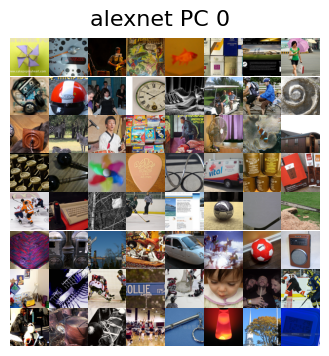

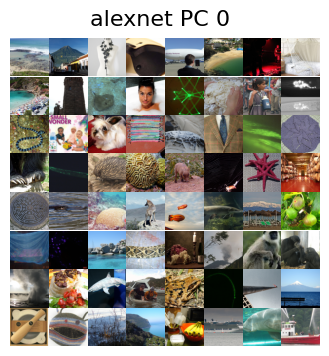

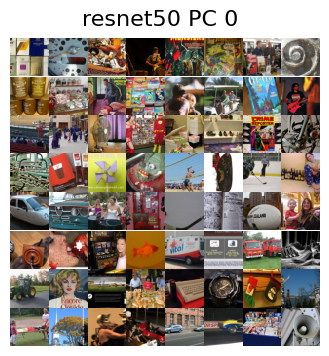

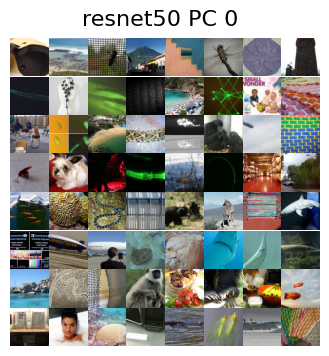

In [24]:
mod1_top = plot_imgs(mod1_topk_imgs, title=f"{model_name1} PC {dim}", square_size=4)
mod1_bot = plot_imgs(mod1_bottomk_imgs, title=f"{model_name1} PC {dim}", square_size=4) 
mod2_top = plot_imgs(mod2_topk_imgs, f"{model_name2} PC {dim}", square_size=4)
mod2_bot = plot_imgs(mod2_bottomk_imgs, f"{model_name2} PC {dim}", square_size=4)

#mod1_top.savefig(f"{path2figs}/{model_name1}_pca_{target_layer1}_dim{dim}_{k}_imgs_top.png")
#mod1_bot.savefig(f"{path2figs}/{model_name1}_pca_{target_layer1}_dim{dim}_{k}_imgs_bottom.png")
#mod2_top.savefig(f"{path2figs}/{model_name2}_pca_{target_layer2}.ln_dim{dim}_{k}_imgs_top.png")
#mod2_bot.savefig(f"{path2figs}/{model_name2}_pca_{target_layer2}.ln_dim{dim}_{k}_imgs_bot.png")

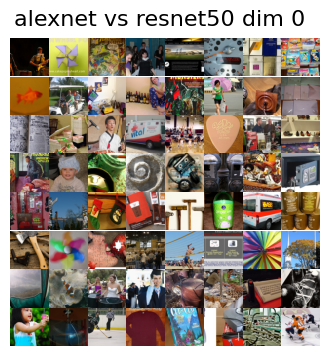

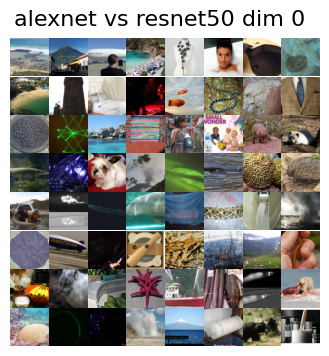

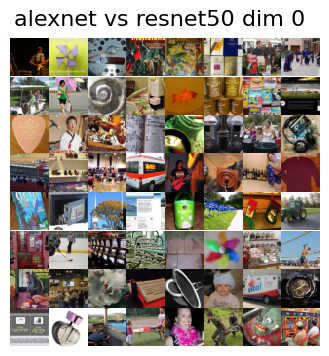

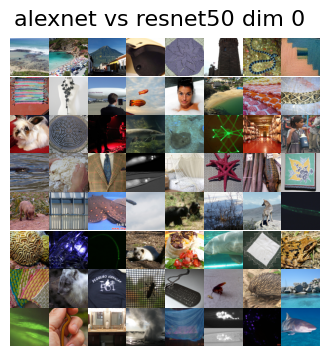

In [25]:
mod1_cca_top_plot = plot_imgs(mod1_topk_imgs_cca, title= f"{model_name1} vs {model_name2} dim {dim}", square_size=4)
mod1_cca_bot_plot = plot_imgs(mod1_bottomk_imgs_cca, title=f"{model_name1} vs {model_name2} dim {dim}", square_size=4)
mod2_cca_top_plot = plot_imgs(mod2_topk_imgs_cca, f"{model_name1} vs {model_name2} dim {dim}", square_size=4)
mod2_cca_bot_plot = plot_imgs(mod2_bottomk_imgs_cca, f"{model_name1} vs {model_name2} dim {dim}", square_size=4)

#mod1_cca_top_plot.savefig(f"{path2figs}/{model_name1}_vs_{model_name2}_{target_layer1}_vs_{target_layer2}_dim{dim}_{k}_imgs_top.png")
#mod1_cca_bot_plot.savefig(f"{path2figs}/{model_name1}_vs_{model_name2}_{target_layer1}_vs_{target_layer2}_dim{dim}_{k}_imgs_bottom.png")
#mod2_cca_top_plot.savefig(f"{path2figs}/{model_name2}_vs_{model_name1}_{target_layer2}_vs_{target_layer1}_dim{dim}_{k}_imgs_top.png")
#mod2_cca_bot_plot.savefig(f"{path2figs}/{model_name2}_vs_{model_name1}_{target_layer2}_vs_{target_layer1}_{k}_imgs_bottom.png")

In [27]:
# TODO load ViT vs alexnet
# wr explained variance
explained_variance_X = np.var(d1, axis=0)
explained_variance_Y = np.var(d2, axis=0)
explained_variance_ratio_X = explained_variance_X / np.sum(np.var(feats1, axis=0))
explained_variance_ratio_Y = explained_variance_Y / np.sum(np.var(feats2, axis=0))

In [89]:
print(explained_variance_ratio_X, explained_variance_ratio_Y)

[0.01749404 0.013206   0.01418448 0.01071939 0.0107659  0.00783107
 0.00738638 0.00884782 0.00694516 0.00605053 0.00642889 0.00719914
 0.00650539 0.00666441 0.00619992 0.00484226 0.00472444 0.0048838
 0.00514402 0.00437793 0.00484534 0.00478863 0.00520895 0.00366569
 0.00433718 0.0040157  0.0036421  0.00483032 0.00388542 0.00335764
 0.00322932 0.00357307 0.00388597 0.00327204 0.00315199 0.0036485
 0.00257446 0.00315228 0.00315859 0.00298205 0.00291227 0.00251343
 0.00290445 0.00275098 0.00234068 0.00236054 0.00248084 0.00239837
 0.00266781 0.00247621] [0.00105066 0.00086692 0.00110051 0.00105307 0.0010268  0.00109318
 0.00118043 0.00118923 0.00100495 0.00130175 0.00113631 0.00106963
 0.00101706 0.0011039  0.00114802 0.00116645 0.00123868 0.00117227
 0.00111031 0.00128265 0.00118911 0.00112759 0.00121877 0.00120008
 0.00116215 0.00125022 0.00111844 0.00113747 0.0011367  0.00127087
 0.00148824 0.0011158  0.00115635 0.00118161 0.00110283 0.00112807
 0.00115907 0.0013534  0.00129795 0.0010

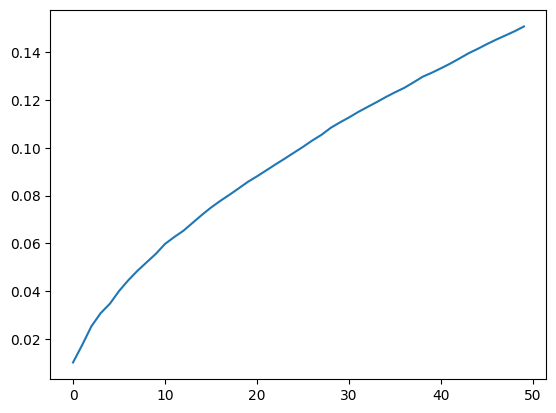

In [28]:
cdf = np.cumsum(explained_variance_ratio_Y)
plt.plot(cdf)

In [11]:
corr_mat = np.corrcoef(d1.T,d2.T)

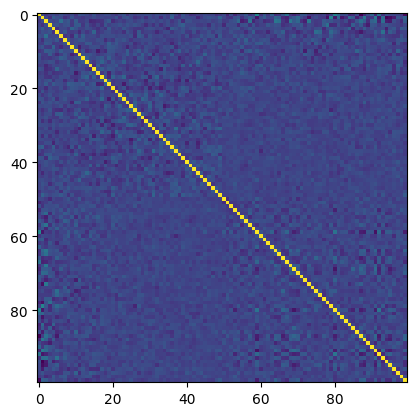

In [12]:
plt.imshow(corr_mat)

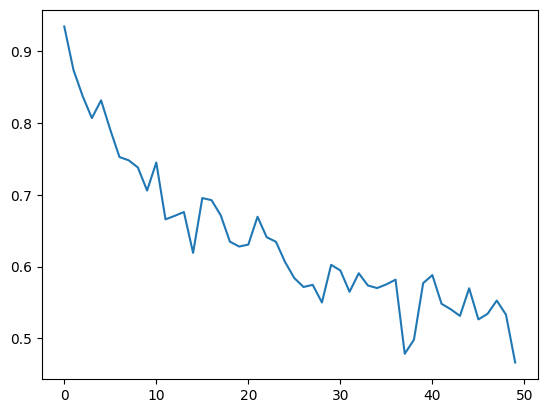

In [17]:
plt.plot(weights_dict["coefs"])